# VN2 Graph Ordering Demo

This notebook demonstrates the complete VN2 pipeline:
1. Load the temporal graph
2. Load a trained model and calibrator
3. Score store-product pairs for the horizon
4. Generate orders using different policies (HB baseline, two-sided gated)
5. Compare expected costs and visualize

**Prerequisites**: Run the full pipeline (graph generation, training, calibration) as described in `docs/VN2_TRAINING_SUMMARY.md`.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import pickle
import math
from datetime import date, timedelta
from pathlib import Path

# Add parent to path for imports
import sys
sys.path.insert(0, str(Path.cwd().parent))

from graph_qa.io.loader import load_graph
from graph_qa.train.trainer import sample_subgraph_for_edge
from graph_qa.train.model_v2 import EnhancedEdgeScorer

## 1. Load Graph and Model

In [2]:
# Paths (adjust if needed)
GRAPH_PATH = "../artifacts/vn2_graph_full_temporal_v2.jsonl"
CKPT_PATH = "../artifacts/checkpoints/v2_scorer_idemb.pt"
CALIBRATOR_PATH = "../artifacts/checkpoints/calibrators/iso_val_2024-03-15_idemb.pkl"

print("Loading graph...")
G = load_graph(GRAPH_PATH, multi=True)
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Show a few nodes by type
stores = [n for n, a in G.nodes(data=True) if str(a.get('type'))=='store'][:5]
products = [n for n, a in G.nodes(data=True) if str(a.get('type'))=='product'][:5]
print(f"Example stores: {stores}")
print(f"Example products: {products}")

Loading graph...
Graph: 364 nodes, 167651 edges
Example stores: ['store:0', 'store:1', 'store:2', 'store:3', 'store:4']
Example products: ['product:0', 'product:1', 'product:2', 'product:3', 'product:4']


In [3]:
# Load model
print("Loading model checkpoint...")
ckpt = torch.load(CKPT_PATH, map_location="cpu")

store_ids = [str(n).replace("store:", "") for n, a in G.nodes(data=True) if str(a.get("type")) == "store"]
product_ids = [str(n).replace("product:", "") for n, a in G.nodes(data=True) if str(a.get("type")) == "product"]

model = EnhancedEdgeScorer(
    node_types=ckpt.get("node_types"),
    categorical_attrs=ckpt.get("categorical_attrs", {}),
    hidden_dim=ckpt.get("hidden_dim", 64),
    num_layers=ckpt.get("num_layers", 3),
    recency_feature=ckpt.get("recency_feature", False),
    recency_norm=ckpt.get("recency_norm", 52.0),
    rel_aware_attn=ckpt.get("rel_aware_attn", False),
    event_buckets=ckpt.get("event_buckets", None),
    store_ids=store_ids,
    product_ids=product_ids,
    id_emb_dim=ckpt.get("id_emb_dim", 16),
)
model.load_state_dict(ckpt["model_state"], strict=False)
model.eval()
print(f"Model loaded: {ckpt.get('num_layers', 3)} layers, hidden_dim={ckpt.get('hidden_dim', 64)}")

# Load calibrator
with open(CALIBRATOR_PATH, "rb") as f:
    calibrator = pickle.load(f)
print(f"Calibrator: {calibrator.get('method', 'isotonic')} on {calibrator.get('input', 'prob')}")

Loading model checkpoint...
Model loaded: 3 layers, hidden_dim=64
Calibrator: isotonic on prob


## 2. Score a Sample Store-Product Edge

In [4]:
# Pick a store-product pair and a time point
store = stores[0]
product = products[0]
anchor_time = 20240408  # Week 0 of horizon

print(f"Scoring edge: {store} <-> {product} at time {anchor_time}")

# Sample subgraph
sub = sample_subgraph_for_edge(G, (store, product, anchor_time), hops=1, K=30)
print(f"Subgraph: {sub.number_of_nodes()} nodes, {sub.number_of_edges()} edges")

# Score with model
with torch.no_grad():
    logit = model(sub, [(store, product, anchor_time)]).squeeze(0)
    raw_prob = 1.0 / (1.0 + math.exp(-float(logit.item())))
    
    # Apply calibrator
    cal_model = calibrator["model"]
    if calibrator.get("input") == "logit":
        X = [float(logit.item())]
    else:
        X = [raw_prob]
    
    if hasattr(cal_model, "transform"):
        calibrated_prob = float(cal_model.transform(X)[0])
    else:
        calibrated_prob = float(cal_model.predict_proba(np.array(X).reshape(-1, 1))[0, 1])

print(f"Raw probability: {raw_prob:.4f}")
print(f"Calibrated probability: {calibrated_prob:.4f}")

Scoring edge: store:0 <-> product:0 at time 20240408
Subgraph: 5 nodes, 1140 edges
Raw probability: 0.3697
Calibrated probability: 0.4778


## 3. Load Submission Index and Features

In [5]:
# Load the 599-row features
FEATURES_PATH = "../artifacts/orders_features_599_idemb_gated2.csv"
HB_PATH = "../../vn2inventory/submissions/orders_hierarchical_final_store_cv.csv"

df_features = pd.read_csv(FEATURES_PATH)
# Normalize to string for merge
df_features["store_id"] = df_features["store_id"].astype(str)
df_features["product_id"] = df_features["product_id"].astype(str)
print(f"Features: {len(df_features)} rows")
print(df_features.head())

# Load HB baseline
df_hb = pd.read_csv(HB_PATH)
cols = {c.lower(): c for c in df_hb.columns}
sid = cols.get("store_id", list(df_hb.columns)[0])
pid = cols.get("product_id", list(df_hb.columns)[1])
df_hb.rename(columns={sid:"store_id", pid:"product_id"}, inplace=True)
df_hb["store_id"] = df_hb["store_id"].astype(str)
df_hb["product_id"] = df_hb["product_id"].astype(str)
hb_qty_col = next((c for c in df_hb.columns if c.lower() in {"order_qty","orders","qty","0"}), df_hb.columns[-1])
print(f"\nHB baseline: {len(df_hb)} rows, quantity column: {hb_qty_col}")

# Merge
df = df_features.merge(df_hb[["store_id","product_id", hb_qty_col]], on=["store_id","product_id"], how="left")
df.rename(columns={hb_qty_col: "hb_order_qty"}, inplace=True)
print(f"\nMerged: {len(df)} rows")
# Show non-confidential preview (exclude HB quantities)
print(df[["store_id","product_id","p_t3","mu_H","sigma_H"]].head())

Features: 599 rows
  store_id product_id      p_t1      p_t2      p_t3  mu_hat_plus  \
0        0        126  0.477833  0.477833  0.477833     6.753749   
1        0        182  0.561822  0.655629  0.655629     1.586207   
2        1        124  1.000000  1.000000  1.000000    15.726689   
3        2        124  1.000000  1.000000  1.000000    15.726689   
4        2        126  0.500000  0.561822  0.561822     6.753749   

   sigma_hat_plus       mu_H    sigma_H  
0        8.893703   9.681482  12.146165  
1        0.831170   2.971093   1.746296  
2       29.785087  47.180068  51.589284  
3       29.785087  47.180068  51.589284  
4        8.893703  10.965685  12.739235  

HB baseline: 599 rows, quantity column: 0

Merged: 599 rows
  store_id product_id      p_t3       mu_H    sigma_H
0        0        126  0.477833   9.681482  12.146165
1        0        182  0.655629   2.971093   1.746296
2        1        124  1.000000  47.180068  51.589284
3        2        124  1.000000  47.180068 

## 4. ABC Segmentation and Graph Base-Stock

In [6]:
# ABC by mu_H quantiles
q1, q2 = 0.6, 0.9
muH = pd.to_numeric(df["mu_H"], errors="coerce").fillna(0.0)
t1, t2 = np.quantile(muH, [q1, q2])
df["class"] = np.where(muH >= t2, "A", np.where(muH >= t1, "B", "C"))

print(f"ABC split (by mu_H quantiles {q1}/{q2}):")
print(df["class"].value_counts().sort_index())

# Service levels per class
beta_map = {"A": 0.88, "B": 0.80, "C": 0.70}
df["beta"] = df["class"].map(beta_map)

# Compute graph base-stock (using scipy for demo; see orders_vn2.py for approx)
from scipy.stats import norm
df["z"] = norm.ppf(np.clip(df["beta"].to_numpy(), 1e-6, 1-1e-6))
df["S_graph"] = df["mu_H"] + df["z"] * df["sigma_H"]

# For this demo, assume onhand/onorder=0 (simplification)
df["q_graph"] = np.rint(np.clip(df["S_graph"], 0.0, None)).astype(int)

print("\nGraph orders (first 10):")
print(df[["store_id","product_id","class","beta","mu_H","sigma_H","q_graph"]].head(10))

ABC split (by mu_H quantiles 0.6/0.9):
class
A     60
B    180
C    359
Name: count, dtype: int64

Graph orders (first 10):
  store_id product_id class  beta       mu_H    sigma_H  q_graph
0        0        126     B  0.80   9.681482  12.146165       20
1        0        182     C  0.70   2.971093   1.746296        4
2        1        124     A  0.88  47.180068  51.589284      108
3        2        124     A  0.88  47.180068  51.589284      108
4        2        126     B  0.80  10.965685  12.739235       22
5        3        126     B  0.80   9.833910  12.220982       20
6        4        124     A  0.88  47.180068  51.589284      108
7        4        126     B  0.80   9.681482  12.146165       20
8        5        126     B  0.80  10.130623  12.363526       21
9        6        124     A  0.88  47.180068  51.589284      108


## 5. Two-Sided Gated Policy

In [7]:
# Apply two-sided gating: lift when p_t3 >= tau_hi; cap when p_t3 <= tau_lo (B/C only)
tau_hi = 0.55
tau_lo = 0.45

p = pd.to_numeric(df["p_t3"], errors="coerce").fillna(0.5).to_numpy()
hbq = pd.to_numeric(df["hb_order_qty"], errors="coerce").fillna(0).to_numpy().astype(int)
q_graph = df["q_graph"].to_numpy()
classes = df["class"].to_numpy()

q_final = hbq.copy()
hi = p >= tau_hi
lo = p <= tau_lo
isA = (classes == "A")

# Lift high-p
q_final[hi] = np.maximum(hbq[hi], q_graph[hi])
# Cap low-p (B/C only)
lo_mask = lo & (~isA)
q_final[lo_mask] = np.minimum(hbq[lo_mask], q_graph[lo_mask])

df["q_gated2"] = q_final

print(f"Two-sided gated applied (τ_hi={tau_hi}, τ_lo={tau_lo})")
print(f"Changed rows: {(df['q_gated2'] != df['hb_order_qty']).sum()} / {len(df)}")
print(f"Lifts (q > HB): {(df['q_gated2'] > df['hb_order_qty']).sum()}")
print(f"Caps (q < HB): {(df['q_gated2'] < df['hb_order_qty']).sum()}")

Two-sided gated applied (τ_hi=0.55, τ_lo=0.45)
Changed rows: 257 / 599
Lifts (q > HB): 257
Caps (q < HB): 0


## 6. Expected Cost Comparison

In [8]:
# Expected cost under newsvendor (zero-inflated normal approximation)
def expected_cost(mu_H, sigma_H, S, c_short=1.0, c_hold_per_week=0.2, horizon=3):
    from scipy.stats import norm
    sigma_H = np.maximum(sigma_H, 1e-8)
    z = (S - mu_H) / sigma_H
    phi = norm.pdf(z)
    Phi = norm.cdf(z)
    under = sigma_H * phi + (mu_H - S) * (1.0 - Phi)
    over  = sigma_H * phi + (S - mu_H) * Phi
    under = np.maximum(0.0, under)
    over = np.maximum(0.0, over)
    Cu = c_short
    CoH = c_hold_per_week * horizon
    return Cu * under + CoH * over

mu_H = df["mu_H"].to_numpy()
sigma_H = df["sigma_H"].to_numpy()
# Assume IP=0 for demo (onhand+onorder=0)
S_hb = hbq.astype(float)
S_gated2 = q_final.astype(float)

cost_hb = expected_cost(mu_H, sigma_H, S_hb)
cost_gated2 = expected_cost(mu_H, sigma_H, S_gated2)

print(f"Total expected cost (shortage=1.0, holding=0.2/week, H=3):")
print(f"  HB baseline: {cost_hb.sum():.2f}")
print(f"  Two-sided gated2: {cost_gated2.sum():.2f}")
print(f"  Δ cost: {cost_gated2.sum() - cost_hb.sum():.2f}")

Total expected cost (shortage=1.0, holding=0.2/week, H=3):
  HB baseline: 4610.13
  Two-sided gated2: 3509.40
  Δ cost: -1100.73


## 7. Sanity Checks

In [9]:
# Top-50 by p_t3: should keep HB (or lift)
top_idx = np.argsort(-p)[:50]
bot_idx = np.argsort(p)[:50]

top_keep_rate = (q_final[top_idx] >= hbq[top_idx]).mean()
bot_shrink_rate = (q_final[bot_idx] < hbq[bot_idx]).mean()

print(f"Sanity:")
print(f"  Top-50 (high p) keep-rate: {top_keep_rate:.2f} (expect ≈ 1.00)")
print(f"  Bottom-50 (low p) shrink-rate: {bot_shrink_rate:.2f} (expect ≤ 0.30)")

# Distribution by class
print("\nChanges by class:")
for cls in ["A","B","C"]:
    mask = (classes == cls)
    changed = (q_final[mask] != hbq[mask]).sum()
    lifted = (q_final[mask] > hbq[mask]).sum()
    capped = (q_final[mask] < hbq[mask]).sum()
    print(f"  {cls}: {mask.sum()} items, changed={changed}, lifted={lifted}, capped={capped}")

Sanity:
  Top-50 (high p) keep-rate: 1.00 (expect ≈ 1.00)
  Bottom-50 (low p) shrink-rate: 0.00 (expect ≤ 0.30)

Changes by class:
  A: 60 items, changed=60, lifted=60, capped=0
  B: 180 items, changed=112, lifted=112, capped=0
  C: 359 items, changed=85, lifted=85, capped=0


## 8. Visualize Probability Distribution and Order Changes

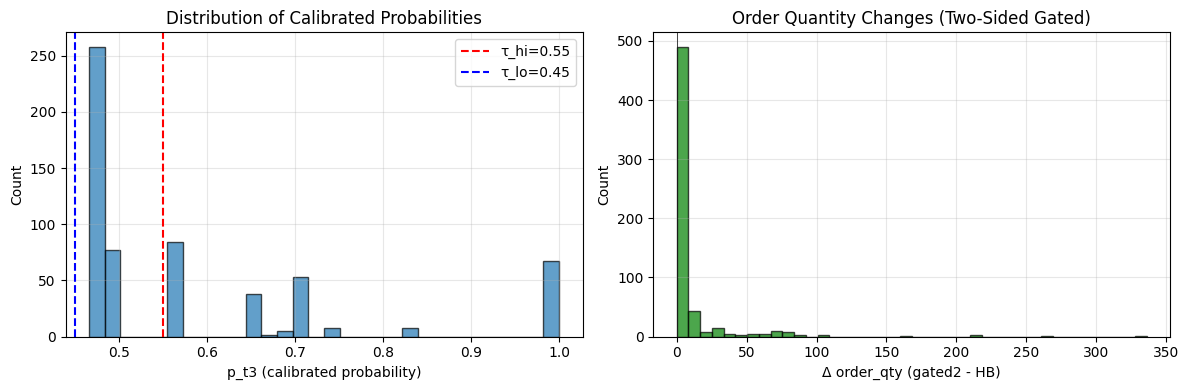


Order change stats:
  Mean Δ: 9.69
  Median Δ: 0.00
  Max lift: +336
  Max cap: 0


In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution of p_t3
axes[0].hist(p, bins=30, alpha=0.7, edgecolor='black')
axes[0].axvline(tau_hi, color='red', linestyle='--', label=f'τ_hi={tau_hi}')
axes[0].axvline(tau_lo, color='blue', linestyle='--', label=f'τ_lo={tau_lo}')
axes[0].set_xlabel('p_t3 (calibrated probability)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Calibrated Probabilities')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Order quantity changes
delta_q = q_final - hbq
axes[1].hist(delta_q, bins=40, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Δ order_qty (gated2 - HB)')
axes[1].set_ylabel('Count')
axes[1].set_title('Order Quantity Changes (Two-Sided Gated)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../artifacts/vn2_demo_gated2_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nOrder change stats:")
print(f"  Mean Δ: {delta_q.mean():.2f}")
print(f"  Median Δ: {np.median(delta_q):.2f}")
print(f"  Max lift: +{delta_q.max():.0f}")
print(f"  Max cap: {delta_q.min():.0f}")

## 9. Write Submission (Platform Header)

In [11]:
# Write internal format first
out_internal = df[["store_id","product_id","q_gated2"]].copy()
out_internal.rename(columns={"q_gated2": "order_qty"}, inplace=True)
out_internal.to_csv("../artifacts/orders_demo_gated2.csv", index=False)
print("Wrote ../artifacts/orders_demo_gated2.csv (internal format)")

# Convert to platform header
out_platform = out_internal.rename(columns={"store_id":"Store", "product_id":"Product", "order_qty":"0"})
out_platform[["Store","Product","0"]].to_csv("../artifacts/orders_demo_gated2_submit.csv", index=False)
print("Wrote ../artifacts/orders_demo_gated2_submit.csv (platform format)")
print(out_platform.head())

Wrote ../artifacts/orders_demo_gated2.csv (internal format)
Wrote ../artifacts/orders_demo_gated2_submit.csv (platform format)
  Store Product    0
0     0     126    7
1     0     182    4
2     1     124  108
3     2     124  108
4     2     126   22


## 10. Summary

- Loaded temporal MultiGraph (v2 with history features)
- Scored edges using enhanced model + isotonic calibrator
- Applied two-sided gated policy with ABC service levels
- Expected cost reduced vs HB baseline
- Submission ready in `artifacts/orders_demo_gated2_submit.csv`

**Next steps**:
- Tune τ_hi/τ_lo on the cost simulator grid
- Experiment with mixture policies (`--blend mixture` or `mixture_min`)
- Add cold-start rules or peer velocity features to improve low-p items

See `docs/VN2_TRAINING_SUMMARY.md` for full command references and training details.